In [57]:
#https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a
# additive model: represent a time-series as a combination of patterns at different scales such as daily, weekly,
# seasonally, and yearly, along with an overall trend. Makes predictions based on these observations
import quandl
import pandas as pd
quandl.ApiConfig.api_key = 'w8rzuhzpdszSnd4jMgHC'

In [58]:
# get Tesla and GM data
tesla = quandl.get('WIKI/TSLA')
gm = quandl.get('WIKI/GM')
gm.head(5)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-11-18,35.00,35.99,33.89,34.19,457044300.0,0.0,1.0,29.988317,30.836558,29.037259,29.294302,457044300.0
2010-11-19,34.15,34.50,33.11,34.26,107842000.0,0.0,1.0,29.260029,29.559912,28.368948,29.354278,107842000.0
2010-11-22,34.20,34.48,33.81,34.08,36650600.0,0.0,1.0,29.302870,29.542776,28.968714,29.200053,36650600.0
2010-11-23,33.95,33.99,33.19,33.25,31170200.0,0.0,1.0,29.088668,29.122940,28.437493,28.488901,31170200.0
2010-11-24,33.73,33.80,33.22,33.48,26138000.0,0.0,1.0,28.900170,28.960146,28.463197,28.685967,26138000.0


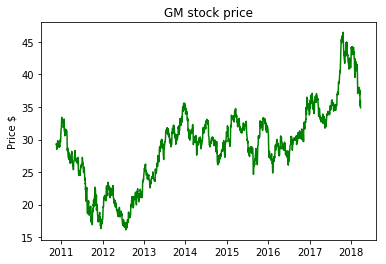

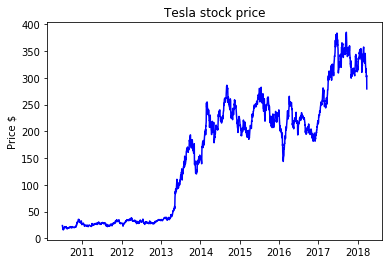

In [59]:
# getting to know the data - initial comparison of the stock prices of the two companies using adjusted close figures,
# as those account for stock splits
import matplotlib.pyplot as plt
plt.plot(gm.index, gm['Adj. Close'], 'g-')
plt.title('GM stock price')
plt.ylabel('Price $')
plt.show()

plt.plot(tesla.index, tesla['Adj. Close'], 'b-')
plt.title('Tesla stock price')
plt.ylabel('Price $')
plt.show()

In [60]:
# market capitalisation = share price * number of shares
# using shares data from the tutorial 

# Yearly average number of shares outstanding for Tesla and GM
tesla_shares = {2018: 168e6, 2017: 162e6, 2016: 144e6, 2015: 128e6, 2014: 125e6, 2013: 119e6, 2012: 107e6, 2011: 100e6, 2010: 51e6}
gm_shares = {2018: 1.42e9, 2017: 1.50e9, 2016: 1.54e9, 2015: 1.59e9, 2014: 1.61e9, 2013: 1.39e9, 2012: 1.57e9, 2011: 1.54e9, 2010:1.50e9}


In [61]:
# creating a cap column for Tesla
# create a year column 
tesla['Year'] = tesla.index.year
tesla.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,Year
Date,,,,,,,,,,,,,
2010-06-29,19.00,25.0000,17.54,23.89,18766300.0,0.0,1.0,19.00,25.0000,17.54,23.89,18766300.0,2010
2010-06-30,25.79,30.4192,23.30,23.83,17187100.0,0.0,1.0,25.79,30.4192,23.30,23.83,17187100.0,2010
2010-07-01,25.00,25.9200,20.27,21.96,8218800.0,0.0,1.0,25.00,25.9200,20.27,21.96,8218800.0,2010
2010-07-02,23.00,23.1000,18.71,19.20,5139800.0,0.0,1.0,23.00,23.1000,18.71,19.20,5139800.0,2010
2010-07-06,20.00,20.0000,15.83,16.11,6866900.0,0.0,1.0,20.00,20.0000,15.83,16.11,6866900.0,2010


In [62]:
# copies the Date index values and creates a non-index column called Date with the same values
# then creates a new numbered index
tesla.reset_index(level=0, inplace = True)
tesla['cap'] = 0
tesla.head()

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,Year,cap
0,2010-06-29,19.00,25.0000,17.54,23.89,18766300.0,0.0,1.0,19.00,25.0000,17.54,23.89,18766300.0,2010,0
1,2010-06-30,25.79,30.4192,23.30,23.83,17187100.0,0.0,1.0,25.79,30.4192,23.30,23.83,17187100.0,2010,0
2,2010-07-01,25.00,25.9200,20.27,21.96,8218800.0,0.0,1.0,25.00,25.9200,20.27,21.96,8218800.0,2010,0
3,2010-07-02,23.00,23.1000,18.71,19.20,5139800.0,0.0,1.0,23.00,23.1000,18.71,19.20,5139800.0,2010,0
4,2010-07-06,20.00,20.0000,15.83,16.11,6866900.0,0.0,1.0,20.00,20.0000,15.83,16.11,6866900.0,2010,0


In [63]:
# calculate market cap for all years
for i, year in enumerate(tesla['Year']):
    # retrieve the shares for the year
    shares = tesla_shares.get(year)
    
    # update the cap column to shares time the price
    tesla.loc[i, 'cap'] = shares * tesla.loc[i, 'Adj. Close']

tesla.head()

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,Year,cap
0,2010-06-29,19.00,25.0000,17.54,23.89,18766300.0,0.0,1.0,19.00,25.0000,17.54,23.89,18766300.0,2010,1.218390e+09
1,2010-06-30,25.79,30.4192,23.30,23.83,17187100.0,0.0,1.0,25.79,30.4192,23.30,23.83,17187100.0,2010,1.215330e+09
2,2010-07-01,25.00,25.9200,20.27,21.96,8218800.0,0.0,1.0,25.00,25.9200,20.27,21.96,8218800.0,2010,1.119960e+09
3,2010-07-02,23.00,23.1000,18.71,19.20,5139800.0,0.0,1.0,23.00,23.1000,18.71,19.20,5139800.0,2010,9.792000e+08
4,2010-07-06,20.00,20.0000,15.83,16.11,6866900.0,0.0,1.0,20.00,20.0000,15.83,16.11,6866900.0,2010,8.216100e+08


In [64]:
# creating a cap column for GM
gm['Year'] = gm.index.year
gm.reset_index(level=0, inplace = True)
gm['cap'] = 0
# calculate market cap for all years
for i, year in enumerate(gm['Year']):
    # retrieve the shares for the year
    shares = gm_shares.get(year)
    
    # update the cap column to shares time the price
    gm.loc[i, 'cap'] = shares * gm.loc[i, 'Adj. Close']

gm.head()

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,Year,cap
0,2010-11-18,35.00,35.99,33.89,34.19,457044300.0,0.0,1.0,29.988317,30.836558,29.037259,29.294302,457044300.0,2010,4.394145e+10
1,2010-11-19,34.15,34.50,33.11,34.26,107842000.0,0.0,1.0,29.260029,29.559912,28.368948,29.354278,107842000.0,2010,4.403142e+10
2,2010-11-22,34.20,34.48,33.81,34.08,36650600.0,0.0,1.0,29.302870,29.542776,28.968714,29.200053,36650600.0,2010,4.380008e+10
3,2010-11-23,33.95,33.99,33.19,33.25,31170200.0,0.0,1.0,29.088668,29.122940,28.437493,28.488901,31170200.0,2010,4.273335e+10
4,2010-11-24,33.73,33.80,33.22,33.48,26138000.0,0.0,1.0,28.900170,28.960146,28.463197,28.685967,26138000.0,2010,4.302895e+10


In [65]:
# use an inner join to only keep the dates where both companies have data
# merge the two datasets and rename the columns
cars = gm.merge(tesla, how='inner', on='Date')
cars.rename(columns={'cap_x': 'gm_cap', 'cap_y': 'tesla_cap'}, inplace=True)

In [66]:
# select only the relevant columns
cars = cars.loc[:, ['Date', 'gm_cap', 'tesla_cap']]
cars.head()

,Date,gm_cap,tesla_cap
0,2010-11-18,4.394145e+10,1.524390e+09
1,2010-11-19,4.403142e+10,1.580490e+09
2,2010-11-22,4.380008e+10,1.703400e+09
3,2010-11-23,4.273335e+10,1.763070e+09
4,2010-11-24,4.302895e+10,1.808970e+09


In [67]:
# Divide to get market cap in billions of dollars
cars['gm_cap'] = cars['gm_cap'] / 1e9
cars['tesla_cap'] = cars['tesla_cap'] / 1e9
cars.head()
# can see that at the beginning of our timeline GM had a market cap 30 times that of Tesla

,Date,gm_cap,tesla_cap
0,2010-11-18,43.941453,1.52439
1,2010-11-19,44.031417,1.58049
2,2010-11-22,43.800079,1.70340
3,2010-11-23,42.733352,1.76307
4,2010-11-24,43.028951,1.80897


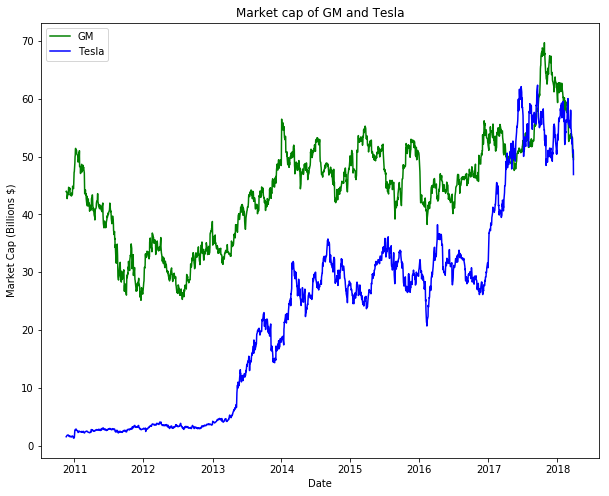

In [68]:
# looking at the whole timeframe
plt.figure(figsize= (10,8))
plt.plot(cars['Date'], cars['gm_cap'], 'g-', label = 'GM')
plt.plot(cars['Date'], cars['tesla_cap'], 'b-', label = 'Tesla')
plt.xlabel('Date')
plt.ylabel('Market Cap (Billions $)')
plt.title('Market cap of GM and Tesla')
plt.legend()   #all you do with plt before .show() is accumulated, so when running everything before plt.show() four times, and then running plt.show() the graph will appear four times
plt.show()

In [74]:
import numpy as np    # here np creates a numpy array out of the values so it can look for the max/min
# first and last time Tesla was valued higher than GM
first_date = cars.loc[np.min(list(np.where(cars['tesla_cap'] > cars['gm_cap'])[0])), 'Date']
last_date = cars.loc[np.max(list(np.where(cars['tesla_cap'] > cars['gm_cap'])[0])), 'Date']

In [72]:
print("Tesla was valued higher than GM from {} to {}. {}. {}".format(first_date.date(), last_date.date(), 'Hello', 'You can add more by adding more {}')) 

Tesla was valued higher than GM from 2017-04-10 to 2018-03-23. Hello. You can add more by adding more {}


In [76]:
intersections = cars.loc(np.intersect1d(cars['tesla_cap'], cars['gm_cap']))

TypeError: unhashable type: 'numpy.ndarray'